# Lane Detection project
#### Author: Moonsu Kang
Date: Nov 15, 2016

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Process
### 1. Grayscale, Blur, Canny Edge
### 2. Utility functions: Masking, Drawing lines, Applying lines to image
### 3. Hough Transform

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


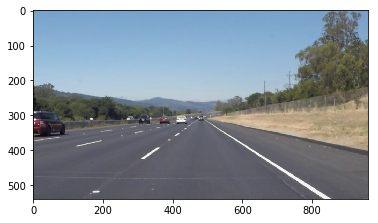

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### 1. Grayscale, Blur, Canny Edge

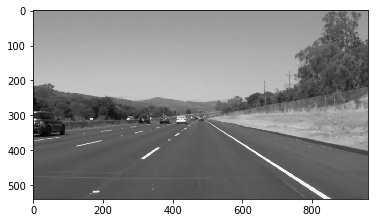

In [21]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray = grayscale(image)
plt.imshow(gray, cmap='gray')

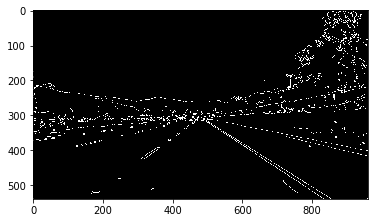

In [31]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

kernel_size = 3
blurimage = gaussian_blur(gray, kernel_size)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform where you take gradient of grayscaled pixels 
    and filter for strong gradient changes.
    http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html
    """
    return cv2.Canny(img, low_threshold, high_threshold)

low_threshold = 50
high_threshold = 100
cannyimage = canny(blurimage, low_threshold, high_threshold)
plt.imshow(cannyimage, cmap='Greys_r')

### 2. Utility functions: Masking, Drawing lines, Applying lines to image

In [35]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    left_slope=[]
    right_slope=[]
    left_midpt=[]
    right_midpt=[]
    max_y2=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=((y2-y1)/(x2-x1))
            if slope<0:
                #left lane
                
                left_slope.append(slope)
                left_midpt.append((x2,y2))
            elif slope > 0:
                right_slope.append(slope)
                right_midpt.append((x1,y1))
    try:
        if len(left_slope)>0:        
            left_slope=float(sum(left_slope))/len(left_slope)
            left_x=sum([x[0] for x in left_midpt])/len(left_midpt)
            left_y=sum([x[1] for x in left_midpt])/len(left_midpt)
            left_int=int(left_y-left_slope*left_x)    
            left_end_x=int(max([x[0] for x in left_midpt]))
            left_end_y=int(left_end_x*left_slope+left_int)
            cv2.line(img, (0,left_int), (left_end_x,left_end_y), color, thickness)   
    except Exception:
        pass
    try:
        if len(right_slope)>0:
            right_slope=float(sum(right_slope))/len(right_slope)
            right_x=float(sum([x[0] for x in right_midpt]))/len(right_midpt)
            right_y=float(sum([x[1] for x in right_midpt]))/len(right_midpt)
            right_int=int(right_y-right_slope*right_x)
            right_end_x=int(min([x[0] for x in right_midpt]))
            right_end_y_1=int(right_end_x*right_slope+right_int)
            right_end_y_2=int(img.shape[1]*right_slope+right_int)    
            cv2.line(img, (right_end_x, right_end_y_1), (img.shape[1],right_end_y_2), color, thickness)
    except Exception:
        pass
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    'img': output of the hough_lines(), An image with lines drawn on it
    Should be a blank image (all black) with lines drawn on it.
    'initial_img': the original image before any processing.
    
    output: 
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### 3. Hough Transformation

In [36]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    input: Canny transformed image
    output: 
    
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # cv2.HoughLinesP output array of endpoints of line segments detected
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    # drawing hough lines on input image
    return line_img

# Parameters for Hough Transformation
#the distance and angular resolution of our grid in Hough space
RHO = 2 
THETA = np.pi/180  
THRESHOLD = 15 
min_line_len= 40
max_line_gap= 20

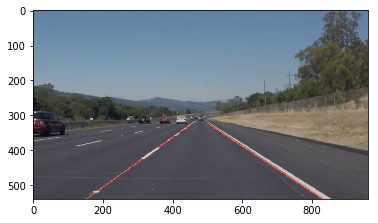

In [38]:
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
region_image = region_of_interest(cannyimage,vertices)
lines = hough_lines(region_image,RHO,THETA,THRESHOLD,min_line_len,max_line_gap)
output=weighted_img(lines,image)
plt.imshow(output)

### Summary

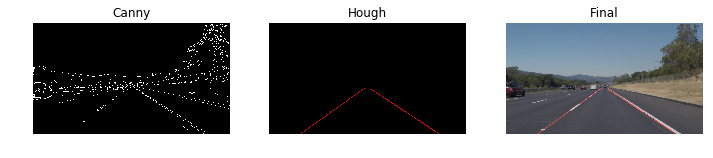

In [50]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(cannyimage,cmap='Greys_r')
plt.title('Canny')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(lines)
plt.title('Hough')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output)
plt.title('Final')
plt.axis('off')
plt.show()

### Applying on video

In [42]:
import imageio
# Needed if ffmpeg is not installed
imageio.plugins.ffmpeg.download()

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    KERNEL_SIZE=5
    LOW_THRESHOLD= 50
    HIGH_THRESHOLD = 100
    RHO = 2
    THETA = np.pi/180
    THRESHOLD = 15 
    min_line_len= 40
    max_line_gap= 20

    image_gray=grayscale(image)
    blur_gray = gaussian_blur(image_gray,KERNEL_SIZE)
    edges = canny(blur_gray, LOW_THRESHOLD, HIGH_THRESHOLD)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    region_image = region_of_interest(edges,vertices)
    lines = hough_lines(region_image,RHO,THETA,THRESHOLD,min_line_len,max_line_gap)
    result=weighted_img(lines,image)
    return result

In [45]:
white_output = 'white_lined.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white_lined.mp4
[MoviePy] Writing video white_lined.mp4


100%|█████████▉| 221/222 [00:05<00:00, 38.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_lined.mp4 

CPU times: user 2.59 s, sys: 535 ms, total: 3.12 s
Wall time: 6.55 s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))